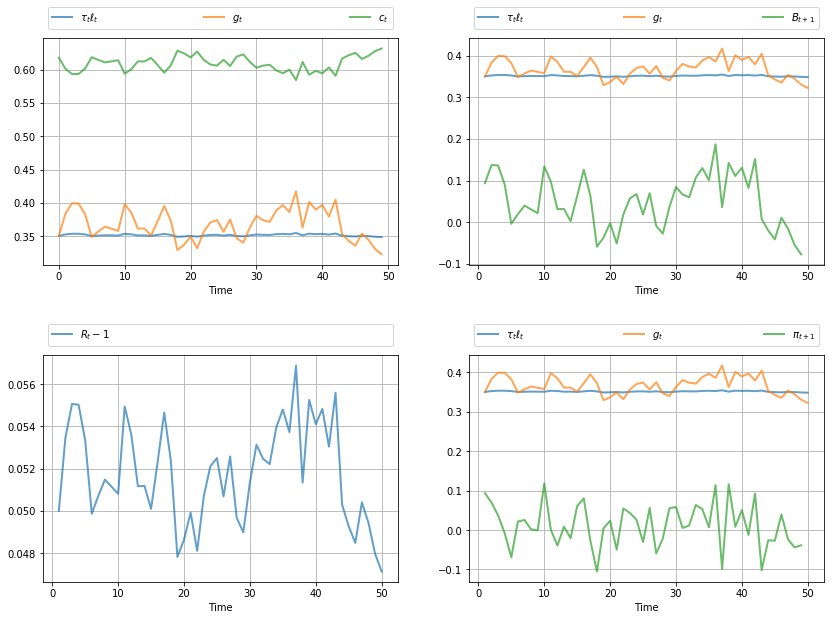

In [1]:
import sys
import numpy as np
from numpy import sqrt, eye, dot, zeros, cumsum
from numpy.random import randn
import scipy.linalg
import matplotlib.pyplot as plt
from collections import namedtuple
from quantecon import nullspace, mc_sample_path, var_quadratic_sum
# == Set up a namedtuple to store data on the model economy == #
Economy = namedtuple('economy',
        ( 'beta',          # Discount factor
          'Sg',         # Govt spending selector matrix
          'Sd',         # Exogenous endowment selector matrix
          'Sb',         # Utility parameter selector matrix
          'Ss',         # Coupon payments selector matrix
          'discrete',   # Discrete or continuous -- boolean
          'proc'))      # Stochastic process parameters

# == Set up a namedtuple to store return values for compute_paths() == #
Path = namedtuple('path',
       ('g',            # Govt spending
        'd',            # Endowment
        'b',            # Utility shift parameter
        's',            # Coupon payment on existing debt
        'c',            # Consumption
        'l',            # Labor
        'p',            # Price
        'Tax',            # Tax rate
        'rvn',          # Revenue
        'B',            # Govt debt
        'R',            # Risk free gross return
        'Rf1',            # One-period risk-free interest rate
        'Radj',            # Cumulative rate of return, adjusted
        'adj'))           # Adjustment factor for Radj


def compute_paths(T, econ):
    """
    Compute simulated time paths for exogenous and endogenous variables.

    Parameters
    ===========
    T: int
        Length of the simulation

    econ: a namedtuple of type 'Economy', containing
         beta          - Discount factor
         Sg         - Govt spending selector matrix
         Sd         - Exogenous endowment selector matrix
         Sb         - Utility parameter selector matrix
         Ss         - Coupon payments selector matrix
         discrete   - Discrete exogenous process (True or False)
         proc       - Stochastic process parameters

    Returns
    ========
    path: a namedtuple of type 'Path', containing
         g            - Govt spending
         d            - Endowment
         b            - Utility shift parameter
         s            - Coupon payment on existing debt
         c            - Consumption
         l            - Labor
         p            - Price
         T            - Tax rate
         rvn          - Revenue
         B            - Govt debt
         R            - Risk free gross return
         Rf1            - One-period risk-free interest rate
         Radj            - Cumulative rate of return, adjusted
         adj            - Adjustment factor for Radj

        The corresponding values are flat numpy ndarrays.

    """

    # == Simplify names == #
    beta, Sg, Sd, Sb, Ss = econ.beta, econ.Sg, econ.Sd, econ.Sb, econ.Ss

    if econ.discrete:
        P, x_vals = econ.proc
    else:
        A, C = econ.proc

    # == Simulate the exogenous process x == #
    if econ.discrete:
        state = mc_sample_path(P, init=0, sample_size=T)
        x = x_vals[:, state]
    else:
        # == Generate an initial condition x0 satisfying x0 = A x0 == #
        nx, nx = A.shape
        x0 = nullspace((eye(nx) - A))
        x0 = -x0 if (x0[nx-1] < 0) else x0
        x0 = x0 / x0[nx-1]

        # == Generate a time series x of length T starting from x0 == #
        nx, nw = C.shape
        x = zeros((nx, T))
        w = randn(nw, T)
        x[:, 0] = x0.T
        for t in range(1, T):
            x[:, t] = dot(A, x[:, t-1]) + dot(C, w[:, t])

    # == Compute exogenous variable sequences == #
    g, d, b, s = (dot(S, x).flatten() for S in (Sg, Sd, Sb, Ss))

    # == Solve for Lagrange multiplier in the govt budget constraint == #
    # In fact we solve for xx = lambda / (1 + 2*lambda).  Here xx is the
    # solution to a quadratic equation a(xx**2 - xx) + b = 0 where
    # a and b are expected discounted sums of quadratic forms of the state.
    Sm = Sb - Sd - Ss
    # == Compute a and b == #
    if econ.discrete:
        ns = P.shape[0]
        F = scipy.linalg.inv(np.identity(ns) - beta * P)
        a0 = 0.5 * dot(F, dot(Sm, x_vals).T**2)[0]
        H = dot(Sb - Sd + Sg, x_vals) * dot(Sg - Ss, x_vals)
        b0 = 0.5 * dot(F, H.T)[0]
        a0, b0 = float(a0), float(b0)
    else:
        H = dot(Sm.T, Sm)
        a0 = 0.5 * var_quadratic_sum(A, C, H, beta, x0)
        H = dot((Sb - Sd + Sg).T, (Sg + Ss))
        b0 = 0.5 * var_quadratic_sum(A, C, H, beta, x0)

    # == Test that xx has a real solution before assigning == #
    warning_msg = """
    Hint: you probably set government spending too {}.  Elect a {}
    Congress and start over.
    """
    disc = a0**2 - 4 * a0 * b0
    if disc >= 0:
        xx = 0.5 * (a0 - sqrt(disc)) / a0
    else:
        print("There is no Ramsey equilibrium for these parameters.")
        print(warning_msg.format('high', 'Republican'))
        sys.exit(0)

    # == Test that the Lagrange multiplier has the right sign == #
    if xx * (0.5 - xx) < 0:
        print("Negative multiplier on the government budget constraint.")
        print(warning_msg.format('low', 'Democratic'))
        sys.exit(0)

    # == Solve for the allocation given xx and x == #
    Sc = 0.5 * (Sb + Sd - Sg - xx * Sm)
    Sl = 0.5 * (Sb - Sd + Sg - xx * Sm)
    c = dot(Sc, x).flatten()
    l = dot(Sl, x).flatten()
    p = dot(Sb - Sc, x).flatten()  # Price without normalization
    Tax = 1 - l / (b - c)
    rvn = l * Tax

    # == Compute remaining variables == #
    if econ.discrete:
        H = dot(Sb - Sc, x_vals) * dot(Sl - Sg, x_vals) - dot(Sl, x_vals)**2
        temp = dot(F, H.T).flatten()
        B = temp[state] / p
        H = dot(P[state, :], dot(Sb - Sc, x_vals).T).flatten()
        R = p / (beta * H)
        temp = dot(P[state, :], dot(Sb - Sc, x_vals).T).flatten()
        adj = p[1:] / temp[:T-1]
    else:
        H = dot(Sl.T, Sl) - dot((Sb - Sc).T, Sl - Sg)
        L = np.empty(T)
        for t in range(T):
            L[t] = var_quadratic_sum(A, C, H, beta, x[:, t])
        B = L / p
        Rinv = (beta * dot(dot(Sb - Sc, A), x)).flatten() / p
        R = 1 / Rinv
        AF1 = dot(Sb - Sc, x[:, 1:])
        AF2 = dot(dot(Sb - Sc, A), x[:, :T-1])
        adj = AF1 / AF2
        adj = adj.flatten()

    Rf1 = B[1:] - R[:T-1] * B[:T-1] - rvn[:T-1] + g[:T-1]
    Radj = cumsum(Rf1 * adj)

    # == Prepare return values == #
    path = Path(g=g,
                d=d,
                b=b,
                s=s,
                c=c,
                l=l,
                p=p,
                Tax=Tax,
                rvn=rvn,
                B=B,
                R=R,
                Rf1=Rf1,
                Radj=Radj,
                adj=adj)

    return path


def gen_fig_1(path):
    """
    The parameter is the path namedtuple returned by compute_paths().  See
    the docstring of that function for details.
    """

    T = len(path.c)

    # == Prepare axes == #
    num_rows, num_cols = 2, 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.4)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].grid()
            axes[i, j].set_xlabel(r'Time')
    bbox = (0., 1.02, 1., .102)
    legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
    p_args = {'lw': 2, 'alpha': 0.7}

    # == Plot consumption, govt expenditure and revenue == #
    ax = axes[0, 0]
    ax.plot(path.rvn, label=r'$\tau_t \ell_t$', **p_args)
    ax.plot(path.g, label=r'$g_t$', **p_args)
    ax.plot(path.c, label=r'$c_t$', **p_args)
    ax.legend(ncol=3, **legend_args)

    # == Plot govt expenditure and debt == #
    ax = axes[0, 1]
    ax.plot(list(range(1, T+1)), path.rvn, label=r'$\tau_t \ell_t$', **p_args)
    ax.plot(list(range(1, T+1)), path.g, label=r'$g_t$', **p_args)
    ax.plot(list(range(1, T)), path.B[1:T], label=r'$B_{t+1}$', **p_args)
    ax.legend(ncol=3, **legend_args)

    # == Plot risk free return == #
    ax = axes[1, 0]
    ax.plot(list(range(1, T+1)), path.R - 1, label=r'$R_t - 1$', **p_args)
    ax.legend(ncol=1, **legend_args)

    # == Plot revenue, expenditure and risk free rate == #
    ax = axes[1, 1]
    ax.plot(list(range(1, T+1)), path.rvn, label=r'$\tau_t \ell_t$', **p_args)
    ax.plot(list(range(1, T+1)), path.g, label=r'$g_t$', **p_args)
    axes[1, 1].plot(list(range(1, T)), path.Rf1, label=r'$\pi_{t+1}$', **p_args)
    ax.legend(ncol=3, **legend_args)

    plt.show()


def gen_fig_2(path):
    """
    The parameter is the path namedtuple returned by compute_paths().  See
    the docstring of that function for details.
    """

    T = len(path.c)

    # == Prepare axes == #
    num_rows, num_cols = 2, 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5)
    bbox = (0., 1.02, 1., .102)
    bbox = (0., 1.02, 1., .102)
    legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
    p_args = {'lw': 2, 'alpha': 0.7}

    # == Plot adjustment factor == #
    ax = axes[0]
    ax.plot(list(range(2, T+1)), path.adj, label=r'$\xi_t$', **p_args)
    ax.grid()
    ax.set_xlabel(r'Time')
    ax.legend(ncol=1, **legend_args)

    # == Plot adjusted cumulative return == #
    ax = axes[1]
    ax.plot(list(range(2, T+1)), path.Radj, label=r'$\Pi_t$', **p_args)
    ax.grid()
    ax.set_xlabel(r'Time')
    ax.legend(ncol=1, **legend_args)

    plt.show()

import numpy as np
from numpy import array
beta= 1 / 1.05
rho, mg = .7, .35
A = np.identity(2)
A[0, :] = rho, mg * (1-rho)
C = np.zeros((2, 1))
C[0,0] = np.sqrt(1 - rho**2) * mg / 10.
Sg = array((1, 0)).reshape(1, 2)
Sd = array((0, 0)).reshape(1, 2)
Sb = array((0, 2.135)).reshape(1, 2)
Ss = array((0, 0)).reshape(1, 2)
economy = Economy(beta=beta,Sg=Sg,Sd=Sd,Sb=Sb,Ss=Ss,discrete=False, proc=(A, C))
T = 50
path = compute_paths(T, economy)
gen_fig_1(path)